# 세팅
---

```
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning
```

In [1]:
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning

Cloning into 'SkillTreePython-DeepLearning'...
remote: Enumerating objects: 790, done.
remote: Counting objects: 100% (363/363), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 790 (delta 220), reused 323 (delta 195), pack-reused 427
Receiving objects: 100% (790/790), 41.83 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (413/413), done.


```
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *
```

In [2]:
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *

# 순환 신경망의 고급 사용법

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 6장 3절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.

---

이 절에서는 순환 신경망의 성능과 일반화 능력을 향상시키기 위한 세 가지의 고급 기술을 살펴보겠습니다. 이 절을 마칠 때면 케라스에서 순환 신경망을 사용하는 대부분의 방법을 알게 될 것입니다. 온도 예측 문제로 세 가지 개념을 모두 시연해 보겠습니다. 이 시계열 데이터는 건물 옥상에 설치된 센서에서 취득한 온도, 기압, 습도 같은 데이터입니다. 이 데이터를 사용하여 마지막 데이터 포인트에서부터 24시간 이후의 온도를 예측하겠습니다. 이 문제는 시계열 데이터에서 일반적으로 나타나는 여러 가지 어려운 점을 가지고 있습니다. 전형적이고 꽤 도전적인 문제입니다.

다음 기법들을 적용하겠습니다.

* 순환 드롭아웃 : 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용합니다.
* 순환 층 스태킹 : 네트워크의 표현 능력을 증가시킵니다(대신 계산 비용이 많이 듭니다).
* 양방향 순환 층 : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킵니다.

## 기온 예측 문제
지금까지 다룬 시퀀스 데이터는 IMDB 데이터셋이나 로이터 데이터셋과 같은 텍스트 데이터입니다. 시퀀스 데이터는 이런 언어 처리 분야뿐만 아니라 훨씬 많은 문제에서 등장합니다. 이 절에 있는 모든 예제는 날씨 시계열 데이터셋을 사용합니다. 이 데이터는 독일 예나 시에 있는 막스 플랑크 생물지구화학 연구소( http://www.bgc-jena.mpg.de/wetter/ )의 지상 관측소에서 수집한 것입니다.

이 데이터셋에는 수년간에 걸쳐 (기온, 기압, 습도, 풍향 등과 같은) 14개의 관측치가 10분마다 기록되어 있습니다. 원본 데이터는 2003년부터 기록되어 있지만 이 예제에서는 2009~2016년 사이의 데이터만 사용합니다. 이 데이터셋은 시계열 수치 데이터를 다루는 법을 익히는 데 안성맞춤입니다. 최근 데이터(몇 일치 데이터 포인트)를 입력으로 사용해 모델을 만들고 24시간 이후의 기온을 예측하겠습니다.

데이터를 살펴보죠:
```
! git clone https://github.com/gilbutITbook/006975.git
```

In [3]:
! git clone https://github.com/gilbutITbook/006975.git

Cloning into '006975'...
remote: Enumerating objects: 102534, done.
remote: Total 102534 (delta 0), reused 0 (delta 0), pack-reused 102534
Receiving objects: 100% (102534/102534), 202.75 MiB | 15.99 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (104042/104042), done.


In [4]:
data_path='/content/006975/datasets/jena_climate/jena_climate_2009_2016.csv'
f = open(data_path)
data=f.read()
f.close()

420,551개 데이터 전체를 넘파이 배열로 바꿉니다:

In [5]:
lines = data.split('\n')
print(len(lines))
header=lines[0]
lines = lines[1:]
print(header)
print(len(lines), lines[0])

420552
"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
420551 01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30


예를 들어 다음은 시간에 따른 기온(섭씨) 그래프입니다:

In [6]:
lines_arr=[]
for i, line in enumerate(lines):
  values = []
  for x in line.split(',')[1:]:
    value = float(x)
    values.append(value)
  lines_arr.append(values)
lines_arr = np.array(lines_arr)
print(lines_arr.shape)

(420551, 14)


In [7]:
temp = lines_arr[:, 1] # (모든 타임, 기온T)

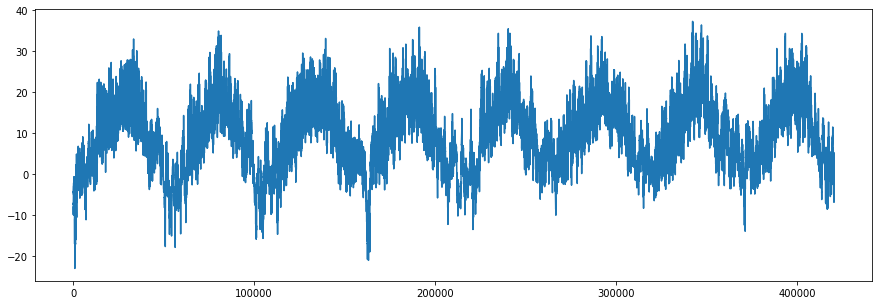

In [8]:
plt.figure(figsize=(15,5))
plt.plot(temp)
plt.show()

이 그래프에서 온도에 주기성이 있다는 것을 잘 볼 수 있습니다.

다음은 기간을 좁혀서 처음 10일간의 온도 데이터를 나타낸 그래프입니다. 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있습니다:

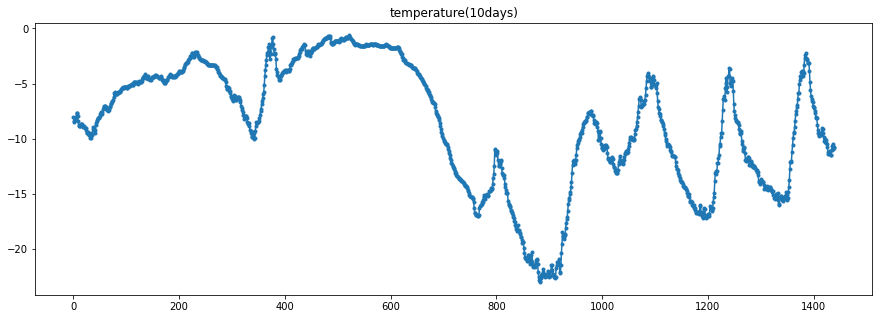

In [9]:
temp = lines_arr[:, 1] 
Tpot = lines_arr[:, 2]
# 10일 : 144*10 = 1440개의 타임 포인트 존재

plt.figure(figsize=(15,5))
plt.plot(temp[:144*10], marker='.')
#plt.plot(Tpot[:144*10], marker='.')
plt.title('temperature(10days)')
plt.show()

이 그래프에서 일별 주기성을 볼 수 있습니다. 특히 마지막 4일간을 보면 확실합니다. 이 데이터는 아주 추운 겨울 중 10일입니다.

지난 몇 달간의 데이터를 사용해 다음 달의 평균 온도를 예측하는 문제는 쉬운 편입니다. 연간 데이터 주기성은 안정적이기 때문입니다. 하지만 하루 하루 데이터를 살펴보면 온도 변화는 매우 불안정합니다. 일자별 수준의 시계열 데이터를 예측할 수 있을까요? 직접 확인해 보겠습니다.

## Preparing the data

이 문제의 정확한 정의는 다음과 같습니다. `lookback` 타임스텝(하나의 타임스텝은 10분입니다)만큼 이전으로 돌아가서 매 `steps` 타임스텝마다 샘플링합니다. 이 데이터를 바탕으로 `delay` 타임스텝 이후의 온도를 예측할 수 있을까요? 사용할 변수는 다음과 같습니다.

* `lookback = 1440` : 10일 전 데이터로 돌아갑니다.
* `steps = 6` : 한 시간마다 데이터 포인트 하나를 샘플링합니다.
* `delay = 144` : 24시간이 지난 데이터가 타깃이 됩니다.

시작하기 전에 두 가지 작업을 처리해야 합니다:

* 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다. 데이터가 이미 수치형이므로 추가적인 벡터화가 필요하지 않습니다. 하지만 데이터에 있는 각 시계열 특성의 범위가 서로 다릅니다(예를 들어 온도는 일반적으로 -20도에서 +30도 사이이고, 밀리바(mb)로 측정된 기압은 1,000 근처의 값입니다). 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸겠습니다.
* float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듭니다. 이 데이터셋에 있는 샘플은 중복이 많습니다(샘플 `N`과 샘플 `N + 1`은 대부분 타임스텝이 비슷합니다). 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용해 그때 그때 배치를 만들겠습니다.

각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리합니다. 처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산합니다:

In [10]:
# 정규화 (feature 별로)
#(샘플개수, 피쳐)
# x-mean / std
mean = lines_arr[:200000].mean(axis=0)
print(mean)
std = lines_arr[:200000].std(axis=0)
print(std)
# 정규화
float_data = (lines_arr-mean)/std
print(lines_arr.shape, float_data.shape)

[ 988.88635885    9.07734895  283.14631345    4.44854725   75.35405895
   13.3829553     9.29695535    4.08591725    5.8752111     9.40521005
 1217.51429655    2.1510037     3.56950915  176.21703355]
[ 8.48043388  8.85249908  8.95324185  7.16584991 16.72731652  7.68914559
  4.19808168  4.84034436  2.66564926  4.25206364 42.48884277  1.53666449
  2.33067298 86.61322998]
(420551, 14) (420551, 14)


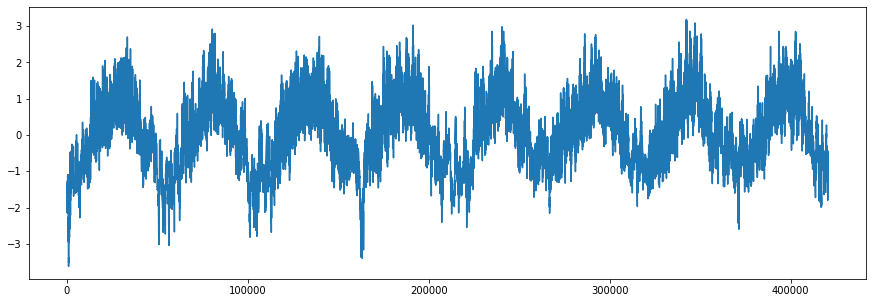

In [21]:
temp = float_data[:,1]
plt.figure(figsize=(15,5))
plt.plot(temp)
plt.show()

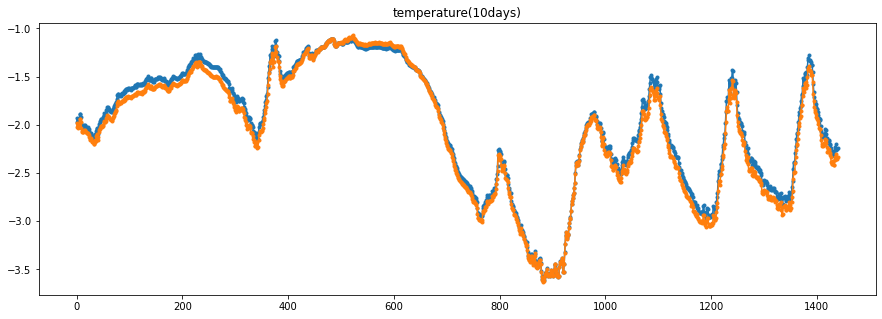

In [23]:
temp = float_data[:, 1] 
Tpot = float_data[:, 2]
# 10일 : 144*10 = 1440개의 타임 포인트 존재

plt.figure(figsize=(15,5))
plt.plot(temp[:144*10], marker='.')
plt.plot(Tpot[:144*10], marker='.')
plt.title('temperature(10days)')
plt.show()

다음은 여기서 사용할 제너레이터입니다. 이 제너레이터 함수는 `(samples, targets)` 튜플을 반복적으로 반환합니다. `samples`는 입력 데이터로 사용할 배치이고 `targets`은 이에 대응되는 타깃 온도의 배열입니다. 이 제너레이터 함수는 다음과 같은 매개변수가 있습니다:

* `data` : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.

In [26]:
def number_generator():
  n = 0
  while True:
    n+=1
    yield n
    if n==5: break


In [27]:
for i in number_generator():
  print(i)

1
2
3
4
5


In [30]:
gen = number_generator()

In [33]:
next(gen)

3

In [11]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

이제 generator 함수를 사용해 훈련용, 검증용, 테스트용으로 세 개의 제너레이터를 만들어 보죠. 각 제너레이터는 원본 데이터에서 다른 시간대를 사용합니다. 훈련 제너레이터는 처음 200,000개 타임스텝을 사용하고 검증 제너레이터는 그 다음 100,000개를 사용하고 테스트 제너레이터는 나머지를 사용합니다.

In [12]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

(128, 240, 14) (128,)


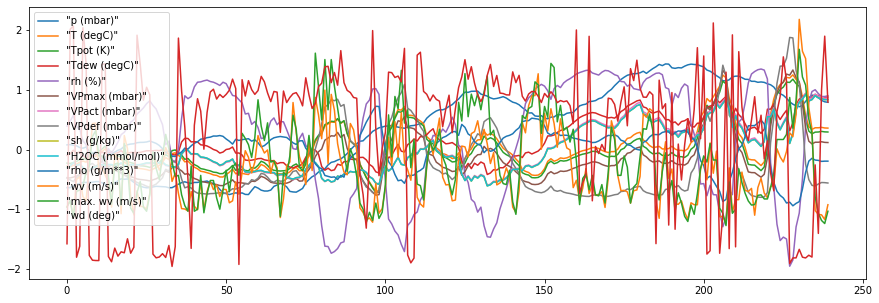

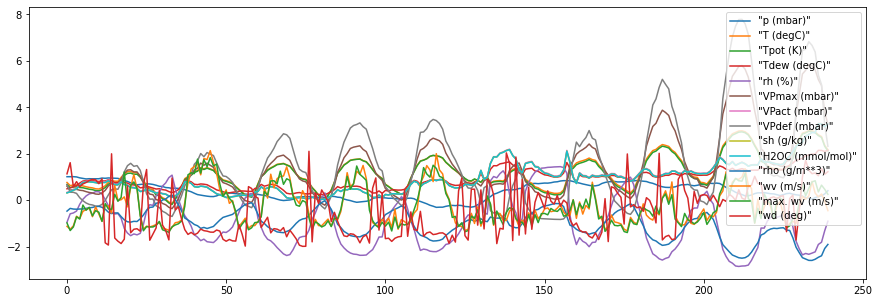

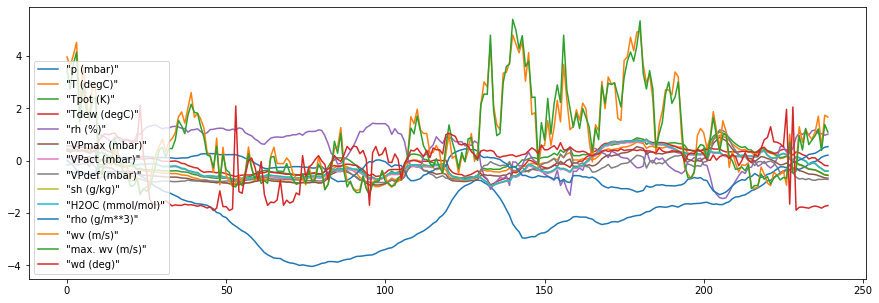

In [39]:
#(bath size, timepoint, feature)
for samples, targets in train_gen:
  print(samples.shape, targets.shape)
  for i in range(3):
    plt.figure(figsize=(15,5))
    plt.plot(samples[i])
    plt.legend(header.split(',')[1:])
    plt.show()
  break

## 상식 수준의 기준점

블랙 박스 같은 딥러닝 모델을 사용해 온도 예측 문제를 풀기 전에 간단한 상식 수준의 해법을 시도해 보겠습니다. 이는 정상 여부 확인을 위한 용도이고 고수준 머신 러닝 모델이라면 뛰어 넘어야 할 기준점을 만듭니다. 이런 상식 수준의 해법은 알려진 해결책이 없는 새로운 문제를 다루어야 할 때 유용합니다. 일부 클래스가 월등히 많아 불균형한 분류 문제가 고전적인 예입니다. 데이터셋에 클래스 A의 샘플이 90%, 클래스 B의 샘플이 10%가 있다면, 이 분류 문제에 대한 상식 수준의 접근법은 새로운 샘플을 항상 클래스 'A'라고 예측하는 것입니다. 이 분류기는 전반적으로 90%의 정확도를 낼 것입니다. 머신 러닝 기반의 모델이라면 90% 이상을 달성해야 유용하다고 볼 수 있습니다. 이따금 이런 기본적인 기준점을 넘어서기가 아주 어려운 경우가 있습니다.

이 경우 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있습니다(오늘 온도는 내일 온도와 비슷할 가능성이 높습니다). 그렇기 때문에 상식 수준의 해결책은 지금으로부터 24시간 후의 온도는 지금과 동일하다고 예측하는 것입니다. 이 방법을 평균 절댓값 오차(MAE)로 평가해 보겠습니다:

```python
np.mean(np.abs(preds - targets))
```

다음은 평가를 위한 반복 루프입니다:

In [13]:
def evaluate_method():
  maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    # samples : (배치개수, 타임포인트, 피쳐개수)
    preds = samples[:,   -1 ,  1] # 다음 타임포인트 온도
    mae = np.mean(np.abs(preds - targets))
    maes.append(mae)
  return np.mean(maes)

basemae = np.round(evaluate_method(),2)
print(basemae)

0.29


출력된 MAE는 0.29입니다. 이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결괏값이 바로 와 닿지는 않습니다. 평균 절댓값 오차 0.29에 표준 편차를 곱하면 섭씨 2.57°C가 됩니다. 평균 절댓값 오차가 상당히 크네요. 이제 딥러닝 모델이 더 나은지 시도해 봅시다.

In [42]:
0.29*std[1]

2.5672247338393377

## 기본적인 머신 러닝 방법

머신 러닝 모델을 시도하기 전에 상식 수준의 기준점을 세워 놓았습니다. 비슷하게 RNN처럼 복잡하고 연산 비용이 많이 드는 모델을 시도하기 전에 간단하고 손쉽게 만들 수 있는 머신 러닝 모델(예를 들면 소규모의 완전 연결 네트워크)을 먼저 만드는 것이 좋습니다. 이를 바탕으로 더 복잡한 방법을 도입하는 근거가 마련되고 실제적인 이득도 얻게 될 것입니다.

다음 코드는 데이터를 펼쳐서 두 개의 `Dense` 층을 통과시키는 완전 연결 네트워크를 보여줍니다. 전형적인 회귀 문제이므로 마지막 `Dense` 층에 활성화 함수를 두지 않았습니다. 손실 함수는 MAE입니다. 상식 수준의 방법에서 사용한 것과 동일한 데이터와 지표를 사용했으므로 결과를 바로 비교해볼 수 있습니다.

In [47]:
timesteps = 240
features = 14
x = layers.Input(shape=(timesteps, features))
y = layers.Flatten()(x)
y = layers.Dense(32, activation='relu')(y)
y = layers.Dense(1)(y)


model = models.Model(x,y)
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(train_gen, validation_data=val_gen,
                    epochs=20,
                    steps_per_epoch=500,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 18s 34ms/step - loss: 1.9241 - val_loss: 0.9878
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.7324 - val_loss: 0.5084
Epoch 3/20
500/500 [==============================] - 13s 27ms/step - loss: 0.3838 - val_loss: 0.3207
Epoch 4/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2875 - val_loss: 0.3037
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2645 - val_loss: 0.3206
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2556 - val_loss: 0.3464
Epoch 7/20
500/500 [==============================] - 17s 33ms/step - loss: 0.2455 - val_loss: 0.3194
Epoch 8/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2372 - val_loss: 0.3135
Epoch 9/20
500/500 [==============================] - 17s 33ms/step - loss: 0.2322 - val_loss: 0.3447
Epoch 10/20
500/500 [==============================] - 17s 33ms/step - loss: 0.227

훈련 손실과 검증 손실의 그래프를 그려 보죠:

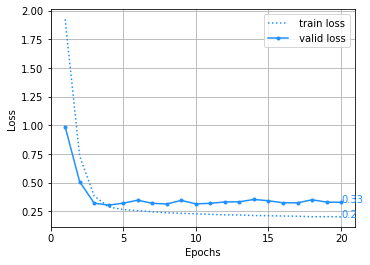

In [48]:
plot_lcurve([history], [''], ['dodgerblue'], x_itv=5)

일부 검증 손실은 학습을 사용하지 않은 기준점에 가깝지만 안정적이지 못합니다. 앞서 기준 모델을 만든 것이 도움이 됩니다. 이 문제는 기준 모델의 성능을 앞지르기가 쉽지 않습니다. 우리가 적용한 상식에는 머신 러닝 모델이 찾지 못한 핵심 정보가 많이 포함되어 있습니다.

간단하고 괜찮은 성능을 내는 모델(상식 수준의 기준 모델)이 데이터와 타깃을 매핑할 수 있다면 왜 훈련한 모델은 이를 찾지 못하고 성능이 낮을까요? 훈련 과정이 찾는 것은 간단한 이 모델이 아니기 때문입니다. 문제 해결을 위해 탐색하는 모델의 공간, 즉 가설 공간은 우리가 매개변수로 설정한 두 개 층을 가진 네트워크의 모든 가능한 가중치의 조합입니다. 이 네트워크는 이미 매우 복잡합니다. 복잡한 모델 공간에서 해결책을 탐색할 때 간단하고 괜찮은 성능을 내는 모델은 찾지 못할 수 있습니다. 심지어 기술적으로 봤을 때 이 가설 공간에 포함되어 있을 때 조차도 말이죠. 이것이 일반적으로 머신 러닝이 가진 심각한 제약 사항입니다. 학습 알고리즘이 특정한 종류의 간단한 모델을 찾도록 하드코딩되지 않았다면, 모델 파라미터를 학습하는 방법은 간단한 문제를 위한 간단한 해결책을 찾지 못할 수 있습니다.

## 첫 번째 순환 신경망

첫 번째 완전 연결 네트워크는 잘 작동하지 않았습니다. 그렇다고 이 문제에 머신 러닝이 적합하지 않다는 뜻은 아닙니다. 앞선 모델은 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개념을 잃어버렸습니다. 대신 인과 관계와 순서가 의미가 있는 시퀀스 데이터 그대로 사용해 보겠습니다. 이런 시퀀스 데이터에 아주 잘 들어맞는 순환 시퀀스 처리 모델을 시도해 보겠습니다. 이 모델은 앞선 모델과 달리 데이터 포인터의 시간 순서를 사용합니다.

이전 절에서 소개한 `LSTM` 층 대신에 2014년에 정준영 등이 개발한 `GRU` 층을 사용하겠습니다. GRU 층은 LSTM과 같은 원리로 작동하지만 조금 더 간결하고 그래서 계산 비용이 덜 듭니다(LSTM 만큼 표현 학습 능력이 높지는 않을 수 있습니다). 계산 비용과 표현 학습 능력 사이의 트레이드오프(trade-off)는 머신 러닝 어디에서나 등장합니다.

In [14]:
timesteps = 240
features = 14
x = layers.Input(shape=(timesteps, features))
y = layers.GRU(32)(x)
y = layers.Dense(1)(y)


model = models.Model(x,y)
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(train_gen, validation_data=val_gen,
                    epochs=20,
                    steps_per_epoch=500,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 21s 29ms/step - loss: 0.3058 - val_loss: 0.2708
Epoch 2/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2811 - val_loss: 0.2672
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2777 - val_loss: 0.2636
Epoch 4/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2715 - val_loss: 0.2644
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2672 - val_loss: 0.2621
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2623 - val_loss: 0.2653
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2578 - val_loss: 0.2664
Epoch 8/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2541 - val_loss: 0.2705
Epoch 9/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2510 - val_loss: 0.2678
Epoch 10/20
500/500 [==============================] - 15s 29ms/step - loss: 0.247

결과를 확인해 보죠:

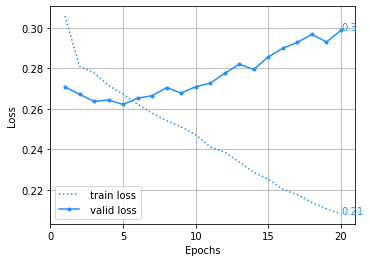

In [15]:
plot_lcurve([history], [''], ['dodgerblue'], x_itv=5)

훨씬 좋군요! 상식 수준의 모델을 크게 앞질렀습니다. 이 그림은 시퀀스를 펼쳐서 처리하는 완전 연결 네트워크에 비해서 순환 네트워크가 이런 종류의 작업에 훨씬 뛰어나다는 것과 머신 러닝의 가치를 보여줍니다.

새로운 검증 MAE는 0.265 이하(크게 과대적합되기 시작하는 곳)이고 정규화되기 전인 섭씨로 복원하면 MAE는 2.35°C입니다. 초기 에러 2.57°C보다는 확실히 낫지만 더 개선할 수 있을 것 같습니다.

## 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

훈련 손실과 검증 손실 곡선을 보면 모델이 과대적합인지 알 수 있습니다. 몇 번의 에포크 이후에 훈련 손실과 검증 손실이 현저하게 벌어지기 시작합니다. 이런 현상을 해결하기 위해 잘 알려진 드롭아웃 기법을 이미 보았습니다. 훈련 데이터를 층에 주입할 때 데이터에 있는 우연한 상관 관계를 깨뜨리기 위해 입력 층의 유닛을 랜덤하게 끄는 기법입니다. 순환 신경망에 드롭아웃을 올바르게 적용하는 방법은 간단하지 않습니다. 순환 층 이전에 드롭아웃을 적용하면 규제에 도움이 되는 것보다 학습에 더 방해되는 것으로 오랫동안 알려졌습니다. 2015년 야린 갈이 베이지안 딥러닝에 관한 박사 논문에서 순환 네트워크에 적절하게 드롭아웃을 사용하는 방법을 알아 내었습니다. 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 동일한 드롭아웃 마스크(동일한 유닛의 드롭 패턴)를 모든 타임스텝에 적용해야 합니다. GRU이나 LSTM 같은 순환 게이트에 의해 만들어지는 표현을 규제하려면 순환 층 내부 계산에 사용된 활성화 함수에 타임스텝마다 동일한 드롭아웃 마스크를 적용해야 합니다(순환 드롭 아웃 마스크). 모든 타임스텝에 동일한 드롭아웃 마스크를 적용하면 네트워크가 학습 오차를 타임스템에 걸쳐 적절하게 전파시킬 것입니다. 타임스텝마다 랜덤한 드롭아웃 마스크를 적용하면 오차 신호가 전파되는 것을 방해하고 학습 과정에 해를 끼칩니다.

야린 갈은 케라스를 사용해 연구를 하였고 케라스 순환 층에 이 기능을 구현하는 데 도움을 주었습니다. 케라스에 있는 모든 순환 층은 두 개의 드롭아웃 매개변수를 가지고 있습니다. `dropout`은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값입니다. `recurrent_dropout`은 순환 상태의 드롭아웃 비율을 정합니다. GRU 층에 드롭아웃과 순환 드롭아웃을 적용해 과대적합에 어떤 영향을 미치는지 살펴보겠습니다. 드롭아웃으로 규제된 네트워크는 언제나 완전히 수렴하는 데 더 오래 걸립니다. 에포크를 두 배 더 늘려 네트워크를 훈련하겠습니다.

In [19]:
timesteps = 240
features = 14
x = layers.Input(shape=(timesteps, features))
y = layers.GRU(32)(x)
y = layers.Dropout(0.5)(y)
y = layers.Dense(1)(y)


model = models.Model(x,y)
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(train_gen, validation_data=val_gen,
                    epochs=40,
                    steps_per_epoch=500,
                    validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 17s 31ms/step - loss: 0.3841 - val_loss: 0.2777
Epoch 2/40
500/500 [==============================] - 16s 33ms/step - loss: 0.3252 - val_loss: 0.2735
Epoch 3/40
500/500 [==============================] - 15s 30ms/step - loss: 0.3227 - val_loss: 0.2717
Epoch 4/40
500/500 [==============================] - 15s 30ms/step - loss: 0.3180 - val_loss: 0.2681
Epoch 5/40
500/500 [==============================] - 15s 30ms/step - loss: 0.3145 - val_loss: 0.2696
Epoch 6/40
500/500 [==============================] - 15s 30ms/step - loss: 0.3121 - val_loss: 0.2663
Epoch 7/40
500/500 [==============================] - 15s 30ms/step - loss: 0.3097 - val_loss: 0.2682
Epoch 8/40
500/500 [==============================] - 16s 33ms/step - loss: 0.3080 - val_loss: 0.2726
Epoch 9/40
500/500 [==============================] - 15s 30ms/step - loss: 0.3081 - val_loss: 0.2637
Epoch 10/40
500/500 [==============================] - 15s 31ms/step - loss: 0.303

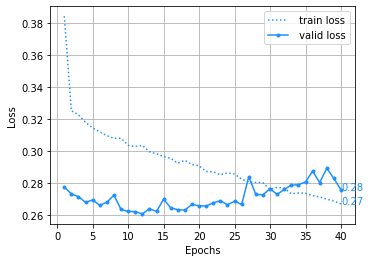

In [20]:
plot_lcurve([history], [''], ['dodgerblue'], x_itv=5)

성공이네요! 30번째 에포크까지 과대적합이 일어나지 않았습니다. 평가 점수는 안정적이지만 이전보다 더 나아지진 않았습니다.

## 스태킹 순환 층

과대적합은 더 이상 없지만 성능상의 병목이 있는 것 같으므로 네트워크의 용량을 늘려야 합니다. 일반적인 머신 러닝 작업 흐름을 기억하세요. (드롭아웃 등을 사용하여 과대적합을 줄이는 기본 단계를 거쳤다고 가정하고) 과대적합이 일어날 때까지 네트워크의 용량을 늘리는 것이 좋습니다. 너무 많이 과대적합되지 않는 한 아직 충분한 용량에 도달한 것이 아닙니다.

네트워크의 용량을 늘리려면 일반적으로 층에 있는 유닛의 수를 늘리거나 층을 더 많이 추가합니다. 순환 층 스태킹은 더 강력한 순환 네트워크를 만드는 고전적인 방법입니다. 예를 들어 구글 번역 알고리즘의 현재 성능은 7개의 대규모 LSTM 층을 쌓은 대규모 모델에서 나온 것입니다.

케라스에서 순환 층을 차례대로 쌓으려면 모든 중간 층은 마지막 타임스텝 출력만이 아니고 전체 시퀀스(3D 텐서)를 출력해야 합니다. `return_sequences=True`로 지정하면 됩니다: 

In [23]:
timesteps = 240
features = 14
x = layers.Input(shape=(timesteps, features))
y = layers.GRU(32, dropout=0.5, return_sequences=True)(x)
y = layers.GRU(64, activation='relu', dropout=0.5)(y)
y = layers.Dense(1)(y)


model = models.Model(x,y)
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(train_gen, validation_data=val_gen,
                    epochs=10,
                    steps_per_epoch=500,
                    validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 343s 681ms/step - loss: 0.3571 - val_loss: 0.2992
Epoch 2/10
500/500 [==============================] - 341s 682ms/step - loss: 0.3237 - val_loss: 0.3055
Epoch 3/10
500/500 [==============================] - 340s 681ms/step - loss: 0.3088 - val_loss: 0.2922
Epoch 4/10
500/500 [==============================] - 335s 669ms/step - loss: 0.2998 - val_loss: 0.2897
Epoch 5/10
500/500 [==============================] - 333s 667ms/step - loss: 0.2909 - val_loss: 0.2892
Epoch 6/10
500/500 [==============================] - 332s 664ms/step - loss: 0.2851 - val_loss: 0.3121
Epoch 7/10
500/500 [==============================] - 331s 663ms/step - loss: 0.2832 - val_loss: 0.2847
Epoch 8/10
500/500 [==============================] - 333s 665ms/step - loss: 0.2773 - val_loss: 0.2891
Epoch 9/10
500/500 [==============================] - 331s 661ms/step - loss: 0.2734 - val_loss: 0.2945
Epoch 10/10
500/500 [==============================] - 331s 662m

결과를 확인해 보죠:

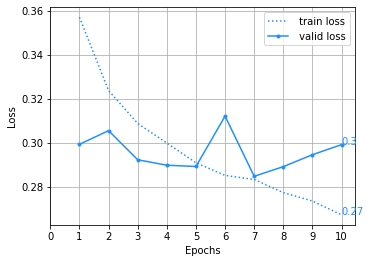

In [24]:
plot_lcurve([history], [''], ['dodgerblue'])

층을 추가하여 성능을 조금 향상시켰지만 크지는 않습니다. 여기서 두 가지 결론을 얻을 수 있습니다:

* 아직 충분히 과대적합을 만들지 못했기 때문에 검증 손실을 향상하기 위해서 층의 크기를 늘릴 수 있습니다. 하지만 적지 않은 계산 비용이 추가됩니다.
* 층을 추가한 만큼 도움이 되지 않았으므로 여기서는 네트워크의 용량을 늘리는 것이 도움이 되지 않는다고 볼 수 있습니다.

## 양방향 RNN 사용하기

이 절에서 소개할 마지막 기법은 양방향 RNN입니다. 양방향 RNN은 RNN의 한 변종이고 특정 작업에서 기본 RNN 보다 훨씬 좋은 성능을 냅니다. 자연어 처리에서는 맥가이버 칼이라고 할 정도로 즐겨 사용됩니다.

RNN은 특히 순서 또는 시간에 민감합니다. 즉, 입력 시퀀스의 타입스텝 순서대로 처리합니다. 타입스텝을 섞거나 거꾸로 하면 RNN이 시퀀스에서 학습하는 표현을 완전히 바꾸어 버립니다. 이는 온도 예측과 같이 순서에 의미가 있는 문제에 잘 맞는 이유이기도 합니다. 양방향 RNN은 RNN이 순서에 민감하다는 성질을 사용합니다. 앞서 보았던 GRU나 LSTM 같은 RNN 두 개를 사용합니다. 각 RNN은 입력 시퀀스를 한 방향(시간의 순서나 반대 순서)으로 처리한 다음 각 표현을 합칩니다. 시퀀스를 양쪽 방향으로 처리하기 때문에 양방향 RNN은 단방향 RNN이 놓치기 쉬운 패턴을 감지할 수 있습니다.

놀랍게도 이 절에 있는 RNN 층이 시간의 순서대로 (오래된 타임스텝이 먼저 나오도록) 시퀀스를 처리하는 것은 근거 없는 결정입니다. 적어도 이 결정을 궁금해하지 않았습니다. 시간의 반대 방향으로 (최근 타임스텝이 먼저 나오도록) 입력 시퀀스를 처리하면 만족할만한 RNN 성능을 낼 수 있을까요? 실제 이렇게 해 보고 결과가 어떤지 확인해 보죠. 해야 할 일은 입력 시퀀스를 시간 차원을 따라 거꾸로 생성하는 데이터 제너레이터 만드는 것 뿐입니다(제너레이터 함수의 마지막 줄을 `yield samples[:, ::-1, :], targets`로 바꿉니다). 이 절의 첫 번째 예제와 동일하게 하나의 GRU 층을 가진 네트워크를 훈련합니다:

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

순서를 뒤집은 GRU는 상식 수준의 기준점보다도 성능이 낮습니다. 이 경우에는 시간 순서대로 처리하는 것이 중요한 역할을 합니다. 사실 이는 당연합니다. 기본적인 GRU 층은 먼 과거보다 최근 내용을 잘 기억합니다. 또한, 최근에 가까운 날씨 데이터 포인트일수록 오래된 데이터 포인트보다 예측에 유용합니다(상식 수준의 기준점이 꽤 강력한 이유입니다). 시간 순서대로 처리하는 네트워크가 거꾸로 처리하는 것보다 성능이 높아야만 합니다. 하지만 자연어 처리를 포함하여 다른 많은 문제에서는 그렇지 않습니다. 문장을 이해하는데 있어서 단어의 중요성은 단어가 문장 어디에 놓여 있는지에 따라 결정되지 않습니다. 같은 기법을 이전 절의 LSTM IMDB 예제에 적용해 보죠:

시간 순서로 훈련한 LSTM과 거의 동일한 성능을 얻을 수 있습니다. 놀랍게도 이런 텍스트 데이터셋에는 순서를 뒤집어 처리하는 것이 시간 순서대로 처리하는 것과 거의 동일하게 잘 작동합니다. 이는 언어를 이해하는 데 단어의 순서가 중요하지만 결정적이지는 않다는 가정을 뒷받침합니다. 거꾸로 된 시퀀스에서 훈련한 RNN은 원래 시퀀스에서 훈련한 것과는 다른 표현을 학습합니다. 이와 비슷하게 시작할 때 죽고 마지막 날 태어나는 삶처럼 실제 세상의 시간이 거꾸로 흘러간다면 우리의 정신 세계가 달라질 것입니다. 머신 러닝에서 다른 표현이 유용하다면 항상 사용할 가치가 있습니다. 이 표현이 많이 다를수록 더 좋습니다. 이 표현이 데이터를 바라보는 새로운 시각을 제공하고 다른 방식에서는 놓칠 수 있는 데이터의 특징을 잡아냅니다. 이런 표현은 작업의 성능을 올리는 데 도움을 줍니다. 이것이 다음 장에서 살펴볼 앙상블의 개념입니다.

양방향 RNN은 이 아이디어를 사용하여 시간 순서대로 처리하는 RNN의 성능을 향상시킵니다. 입력 시퀀스를 양쪽 방향으로 바라보기 때문에, 드러나지 않은 다양한 표현을 얻어 시간 순서대로 처리할 때 놓칠 수 있는 패턴을 잡아 냅니다.

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

케라스에서는 `Bidirectional` 층을 사용하여 양방향 RNN을 만듭니다. 이 클래스는 첫 번째 매개변수로 순환 층의 객체를 전달받습니다. `Bidirectional` 클래스는 전달받은 순환 층으로 새로운 두 번째 객체를 만듭니다. 하나는 시간 순서대로 입력 시퀀스를 처리하고 다른 하나는 반대 순서로 입력 시퀀스를 처리합니다. IMDB 감성 분석 문제에 이를 적용해 보죠:

여기서 얻은 검증 정확도는 88% 정도로 이전 절에서 사용했던 일반 LSTM보다 조금 더 성능이 높습니다. 이 모델은 조금 더 일찍 과대적합되는 것 같습니다. 양방향 순환 층이 단방향 LSTM보다 모델 파라미터가 두 배 많기 때문에 놀라운 일은 아닙니다. 규제를 조금 추가한다면 양항뱡 순환 층을 사용하는 것이 이 작업에 더 적합해 보입니다.

이제 동일한 방식을 온도 예측 문제에 적용해 보죠:

이 네트워크는 일반 GRU 층과 비슷한 성능을 냅니다. 이유는 쉽게 이해할 수 있습니다. 모든 예측 성능은 시간 순서대로 처리하는 네트워크의 절반에서 옵니다. 시간 반대 순서로 처리하는 절반은 이런 작업에 성능이 매우 좋지 않기 때문입니다(최근의 정보가 오래 전의 정보보다 훨씬 더 중요합니다).

## 더 나아가서

온도 예측 문제의 성능을 향상하기 위해 시도해 볼 수 있는 것들이 많이 있습니다.

* 스태킹한 각 순환 층의 유닛 수를 조정합니다. 지금 설정은 대부분 임의로 한 것이라 최적화가 덜 되었을 것입니다.
* `RMSprop` 옵티마이저가 사용한 학습률을 조정합니다.
* `GRU` 대신 `LSTM` 층을 사용합니다.
* 순환 층 위에 용량이 큰 완전 연결된 회귀 층을 사용합니다. 즉 유닛 수가 많은 `Dense` 층이나 `Dense` 층을 스태킹합니다.
* 최종적으로 (검증 MAE 기준으로 봤을 때) 최선의 모델을 테스트 세트에서 확인해야 합니다. 이를 잊으면 검증 세트에 과대적합된 네트워크 구조를 만들게 될 것입니다.

늘 그렇듯이 딥러닝은 과학보다는 예술에 가깝습니다. 어떤 문제에 적합하거나 그렇지 않은 가이드라인은 제시할 수 있지만 결국 모든 문제는 다릅니다. 경험을 바탕으로 다른 전략들을 시도해 봐야 합니다. 현재는 문제를 해결하는 최선의 방법을 미리 알 수 있는 이론이 없습니다. 반복해서 시도해야 합니다.



Epoch 1/10
500/500 [==============================] - 311s 618ms/step - loss: 0.3133 - val_loss: 0.2852
Epoch 2/10
500/500 [==============================] - 305s 609ms/step - loss: 0.2866 - val_loss: 0.2730
Epoch 3/10
500/500 [==============================] - 303s 606ms/step - loss: 0.2761 - val_loss: 0.2670
Epoch 4/10
500/500 [==============================] - 297s 593ms/step - loss: 0.2707 - val_loss: 0.2641
Epoch 5/10
500/500 [==============================] - 287s 575ms/step - loss: 0.2650 - val_loss: 0.2717
Epoch 6/10
500/500 [==============================] - 285s 570ms/step - loss: 0.2620 - val_loss: 0.2758
Epoch 7/10
500/500 [==============================] - 286s 573ms/step - loss: 0.2573 - val_loss: 0.2720
Epoch 8/10
500/500 [==============================] - 282s 563ms/step - loss: 0.2529 - val_loss: 0.2680
Epoch 9/10
500/500 [==============================] - 282s 564ms/step - loss: 0.2489 - val_loss: 0.2724
Epoch 10/10
500/500 [==============================] - 280s 561m

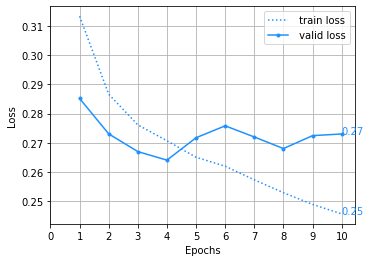

In [25]:
# 스태킹한 각 순환 층의 유닛 수를 조정합니다. 지금 설정은 대부분 임의로 한 것이라 최적화가 덜 되었을 것입니다.

timesteps = 240
features = 14
x = layers.Input(shape=(timesteps, features))
y = layers.GRU(16, return_sequences=True)(x)
y = layers.GRU(32, activation='relu')(y)
y = layers.Dense(1)(y)


model = models.Model(x,y)
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(train_gen, validation_data=val_gen,
                    epochs=10,
                    steps_per_epoch=500,
                    validation_steps=val_steps)
plot_lcurve([history], [''], ['dodgerblue'])

Epoch 1/10
500/500 [==============================] - 16s 30ms/step - loss: 0.5705 - val_loss: 0.2955
Epoch 2/10
500/500 [==============================] - 14s 28ms/step - loss: 0.4060 - val_loss: 0.2843
Epoch 3/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3663 - val_loss: 0.2823
Epoch 4/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3527 - val_loss: 0.2800
Epoch 5/10
500/500 [==============================] - 14s 27ms/step - loss: 0.3428 - val_loss: 0.2803
Epoch 6/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3368 - val_loss: 0.2781
Epoch 7/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3370 - val_loss: 0.2767
Epoch 8/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3319 - val_loss: 0.2772
Epoch 9/10
500/500 [==============================] - 15s 29ms/step - loss: 0.3296 - val_loss: 0.2758
Epoch 10/10
500/500 [==============================] - 14s 28ms/step - loss: 0.328

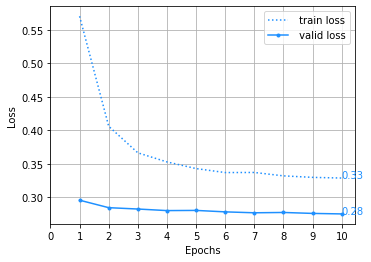

In [29]:
from tensorflow.keras import optimizers
# RMSprop 옵티마이저가 사용한 학습률을 조정합니다.

timesteps = 240
features = 14
x = layers.Input(shape=(timesteps, features))
y = layers.GRU(32)(x)
y = layers.Dropout(0.5)(y)
y = layers.Dense(1)(y)


model = models.Model(x,y)
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), loss='mae')
history = model.fit(train_gen, validation_data=val_gen,
                    epochs=10,
                    steps_per_epoch=500,
                    validation_steps=val_steps)
plot_lcurve([history], [''], ['dodgerblue'])

Epoch 1/10
500/500 [==============================] - 16s 29ms/step - loss: 0.3643 - val_loss: 0.2753
Epoch 2/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3246 - val_loss: 0.2721
Epoch 3/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3197 - val_loss: 0.2693
Epoch 4/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3133 - val_loss: 0.2668
Epoch 5/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3124 - val_loss: 0.2648
Epoch 6/10
500/500 [==============================] - 15s 30ms/step - loss: 0.3058 - val_loss: 0.2720
Epoch 7/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3061 - val_loss: 0.2662
Epoch 8/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3033 - val_loss: 0.2691
Epoch 9/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3012 - val_loss: 0.2694
Epoch 10/10
500/500 [==============================] - 14s 28ms/step - loss: 0.301

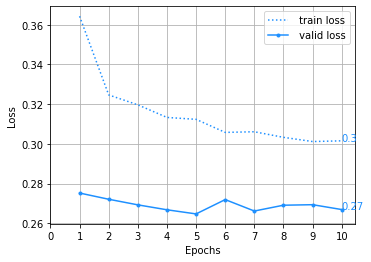

In [30]:
# GRU 대신 LSTM 층을 사용합니다.

timesteps = 240
features = 14
x = layers.Input(shape=(timesteps, features))
y = layers.LSTM(32)(x)
y = layers.Dropout(0.5)(y)
y = layers.Dense(1)(y)


model = models.Model(x,y)
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(train_gen, validation_data=val_gen,
                    epochs=10,
                    steps_per_epoch=500,
                    validation_steps=val_steps)
plot_lcurve([history], [''], ['dodgerblue'])

Epoch 1/10
500/500 [==============================] - 16s 29ms/step - loss: 0.3490 - val_loss: 0.2740
Epoch 2/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3174 - val_loss: 0.2697
Epoch 3/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3084 - val_loss: 0.2647
Epoch 4/10
500/500 [==============================] - 15s 29ms/step - loss: 0.3048 - val_loss: 0.2646
Epoch 5/10
500/500 [==============================] - 14s 29ms/step - loss: 0.2986 - val_loss: 0.2612
Epoch 6/10
500/500 [==============================] - 14s 28ms/step - loss: 0.2927 - val_loss: 0.2652
Epoch 7/10
500/500 [==============================] - 14s 28ms/step - loss: 0.2882 - val_loss: 0.2686
Epoch 8/10
500/500 [==============================] - 14s 28ms/step - loss: 0.2832 - val_loss: 0.2681
Epoch 9/10
500/500 [==============================] - 14s 28ms/step - loss: 0.2774 - val_loss: 0.2744
Epoch 10/10
500/500 [==============================] - 14s 28ms/step - loss: 0.275

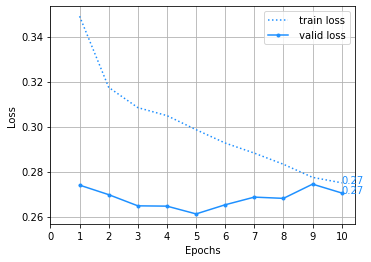

In [31]:
# 순환 층 위에 용량이 큰 완전 연결된 회귀 층을 사용합니다. 즉 유닛 수가 많은 Dense 층이나 Dense 층을 스태킹합니다
timesteps = 240
features = 14
x = layers.Input(shape=(timesteps, features))
y = layers.LSTM(32)(x)
y = layers.Dense(64, activation='relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(1)(y)


model = models.Model(x,y)
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(train_gen, validation_data=val_gen,
                    epochs=10,
                    steps_per_epoch=500,
                    validation_steps=val_steps)
plot_lcurve([history], [''], ['dodgerblue'])

## 요약

다음은 이번 절에서 배운 것들입니다.

* 4장에서 처음 배웠던 것처럼 새로운 문제를 해결할 때는 선택한 지표에서 상식 수준의 기준점을 설정하는 것이 좋습니다. 기준점을 가지고 있지 않으면 실제 향상이 되었는지 알 수 없습니다.
* 계산 비용을 추가할지 판단하기 위해서 비용이 비싼 모델 전에 간단한 모델을 시도합니다.
* 시간 순서가 중요한 데이터가 있다면 순환 층이 적합합니다. 시계열 데이터를 펼쳐서 처리하는 모델의 성능을 쉽게 앞지를 것입니다.
* 순환 네트워크에 드롭아웃을 사용하려면 타임스텝 동안 일정한 드롭아웃 마스크와 순환 드롭아웃 마스크를 사용해야 합니다. 둘 다 케라스 순환 층에 포함되어 있습니다. 순환 층에 있는 `dropout`과 `recurrent_dropout` 매개변수를 사용하면 됩니다.
* 스태킹 RNN은 단일 RNN 층보다 더 강력한 표현 능력을 제공합니다. 하지만 계산 비용이 많이 들기 때문에 항상 시도할 가치가 있지는 않습니다. (기계 번역 같은) 복잡한 문제에서 확실히 도움이 되지만 작고 간단한 문제에서는 항상 그렇지 않습니다.
* 양쪽 방향으로 시퀀스를 바라보는 양방향 RNN은 자연어 처리 문제에 유용합니다. 하지만 최근의 정보가 오래된 것보다 훨씬 의미 있는 시퀀스 데이터에는 잘 작동하지 않습니다.

여기서 자세히 다루지 않은 두 가지 중요한 개념이 있습니다. 순환 어텐션과 시퀀스 마스킹입니다. 둘 다 자연어 처리에 깊게 관련되어 있고 온도 예측 문제에는 적합하지 않습니다. 이 책을 끝내고 앞으로 공부할 목록으로 남겨 두겠습니다.